In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv('synthetic_transaction_data_50000.csv')


print(df.shape)
df.head()


(50000, 13)


,item_id,item_name,brand,category,best_price,unit_price,total_price,discount,quantity,unit_type,date,sub_category,transaction_id
0,16318,Bref Toilet Cleaner,McKenzie's,Cleaning & Maintenance,9.89,12.44,32.94,11.74,3,each,1/01/2025,Surface Cleaners,8e76f280-caa7-4c63-b24f-8c2e0d63e0f9
1,16318,Bref Toilet Cleaner,McKenzie's,Cleaning & Maintenance,9.95,13.24,36.29,31.47,4,Kg,1/02/2024,Surface Cleaners,c6b8648c-d4f4-43cb-888c-992523addbad
2,16318,Bref Toilet Cleaner,McKenzie's,Cleaning & Maintenance,6.61,7.55,16.33,27.92,3,each,1/02/2024,Surface Cleaners,ad3fdee6-58b3-47a7-a955-aa87b008b6cc
3,16318,Bref Toilet Cleaner,McKenzie's,Cleaning & Maintenance,8.73,11.16,13.59,39.13,2,Kg,1/03/2024,Surface Cleaners,4ec5f220-fdf8-4903-af74-de03ab3a1f44
4,16318,Bref Toilet Cleaner,McKenzie's,Cleaning & Maintenance,4.88,9.26,26.18,43.45,5,each,1/03/2025,Surface Cleaners,ca3e7d71-38b3-427a-a531-cb93ece75116


In [2]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)


In [ ]:
arima_series = df.groupby('date')['best_price'].mean().sort_index()


print(arima_series.head())
print(f"Unique dates: {arima_series.shape[0]}")


date
2024-01-01    5.413670
2024-01-02    5.222800
2024-01-03    5.850172
2024-01-04    5.944737
2024-01-05    6.137391
Name: best_price, dtype: float64
Unique dates: 487


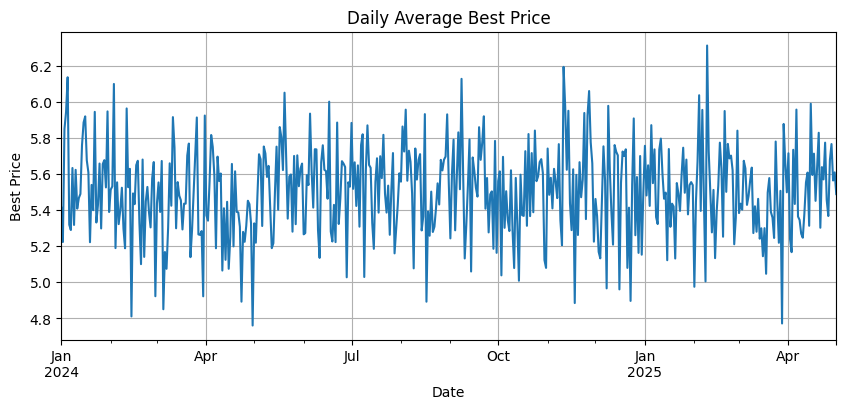

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
arima_series.plot(title="Daily Average Best Price")
plt.ylabel("Best Price")
plt.xlabel("Date")
plt.grid(True)
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test
adf_result = adfuller(arima_series)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

if adf_result[1] > 0.05:
    print(" Series is NOT stationary. Differencing will be needed.")
else:
    print(" Series is stationary. You can proceed with ARIMA.")


ADF Statistic: -21.696496389552433
p-value: 0.0
✅ Series is stationary. You can proceed with ARIMA.


In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(arima_series, order=(1, 0, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


C:\Users\anjup\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\anjup\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\anjup\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             best_price   No. Observations:                  487
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -20.145
Date:                Wed, 14 May 2025   AIC                             48.290
Time:                        17:23:31   BIC                             65.043
Sample:                    01-01-2024   HQIC                            54.871
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5060      0.015    375.914      0.000       5.477       5.535
ar.L1          0.9065      0.159      5.695      0.000       0.595       1.218
ma.L1         -0.8799      0.181     -4.871      0.0

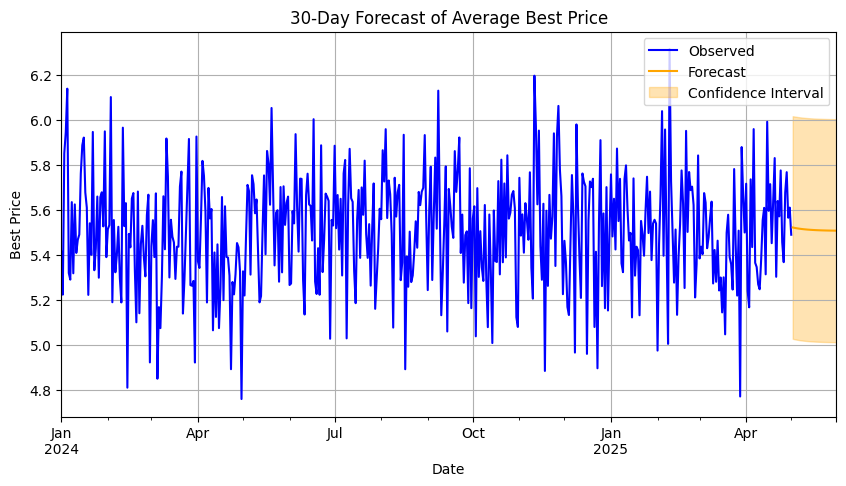

In [7]:
# Forecast next 30 steps
forecast = model_fit.get_forecast(steps=30)
forecast_values = forecast.predicted_mean
confidence_int = forecast.conf_int()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
arima_series.plot(label='Observed', color='blue')
forecast_values.plot(label='Forecast', color='orange')
plt.fill_between(forecast_values.index, confidence_int.iloc[:, 0], confidence_int.iloc[:, 1], 
                 color='orange', alpha=0.3, label='Confidence Interval')
plt.title("30-Day Forecast of Average Best Price")
plt.xlabel("Date")
plt.ylabel("Best Price")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from pmdarima import auto_arima

# Let auto_arima search for the best (p,d,q)
auto_model = auto_arima(arima_series,
                        seasonal=False,     # No seasonality here
                        trace=True,         # Show what it's trying
                        suppress_warnings=True,
                        stepwise=True)      # Use a fast greedy search

# Summary of the selected model
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=4.60 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3046.445, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2440.043, Time=0.36 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=2.83 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2000.036, Time=0.94 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=71.252, Time=1.00 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=4.23 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1648.673, Time=1.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=3.69 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=6.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=50.344, Time=2.70 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=48.404, Time=0.81 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=48.117, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=46.202, Time=0.15 sec
 ARIMA(

C:\Users\anjup\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\anjup\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


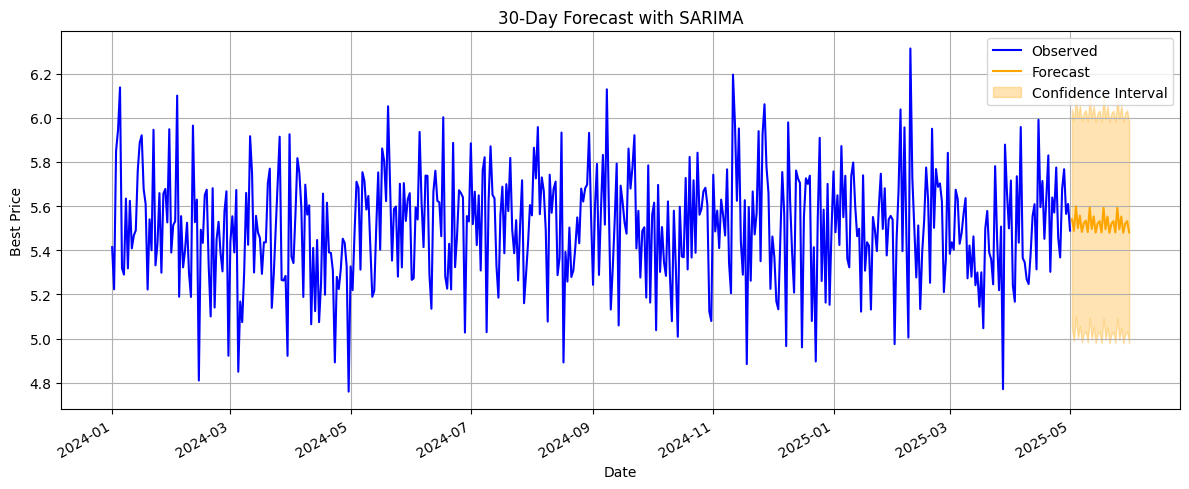

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Fit SARIMA: (p,d,q)x(P,D,Q,s)
sarima_model = SARIMAX(
    arima_series,               # Corrected variable name
    order=(1, 0, 1),            # Non-seasonal part
    seasonal_order=(1, 0, 1, 7),  # Weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit(disp=False)

# Forecast
forecast_steps = 30
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(arima_series, label='Observed', color='blue')
forecast.predicted_mean.plot(label='Forecast', color='orange')
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='orange',
    alpha=0.3,
    label='Confidence Interval'
)
plt.title('30-Day Forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Best Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\anjup\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\anjup\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE:  0.1947
RMSE: 0.2469
MAPE: 3.61%


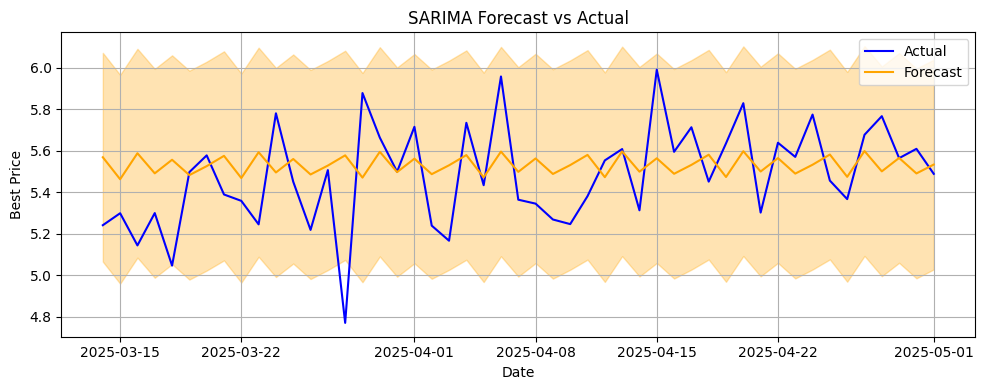

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Split the data (90% train, 10% test)
train_size = int(len(arima_series) * 0.9)
train, test = arima_series[:train_size], arima_series[train_size:]

# 2. Fit SARIMA model on training data
model = SARIMAX(train,
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# 3. Forecast for test period
forecast = model_fit.get_forecast(steps=len(test))
predicted = forecast.predicted_mean

# 4. Evaluation
mae = mean_absolute_error(test, predicted)
rmse = np.sqrt(mean_squared_error(test, predicted))
mape = np.mean(np.abs((test - predicted) / test)) * 100

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# Optional: Plot comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, predicted, label='Forecast', color='orange')
plt.fill_between(test.index, 
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1],
                 color='orange', alpha=0.3)
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Best Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
